Total points for this HW: 10

Make sure that you run all your codes and that all results are printed.

Please note: Copying and pasting other people's work is absolutely prohibited. Any such cases will be reported to CUSP's education team and severely punished. Discussion is encouraged, and feel free to exchange ideas with your classmates, but please write your own code and do your own work.

In [1]:
from IPython.display import Image
import pandas as pd
import numpy as np

import pgmpy
from pgmpy.estimators import HillClimbSearch,K2Score, BicScore
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import BayesianEstimator
from pgmpy.factors.discrete import TabularCPD
from collections import defaultdict
from pgmpy.inference import VariableElimination
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import fcluster

import warnings
warnings.simplefilter(action='ignore')

## Question 1 (15%) 

### This task is to be done with manual calculations rather than using Python.

Given the following learned Bayesian network structure explaining the relationships between variables in container shipping data:

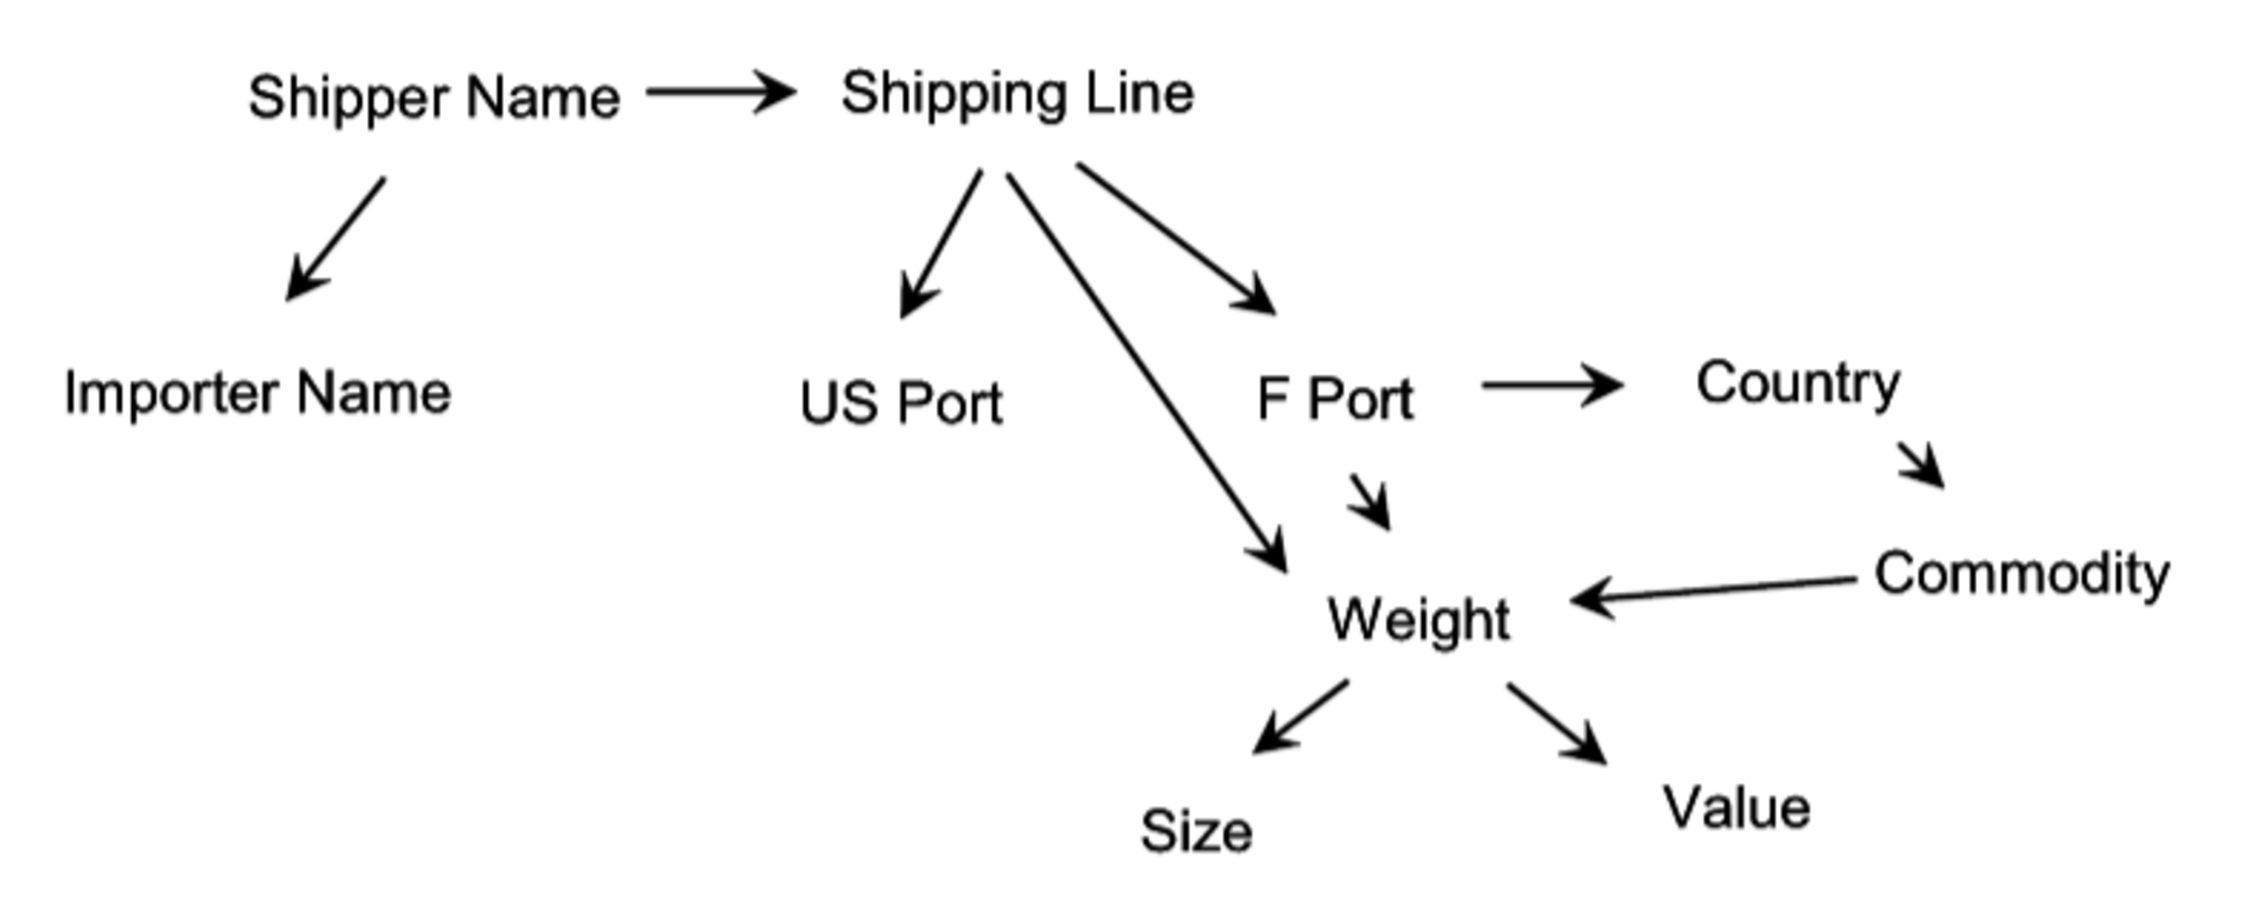

In [2]:
Image('HW3Q1.png')

### 1) Which of the following conditional independence relationships hold? Choose “Independent” or “Dependent” for each (6%):

CI (Shipper Name, Value | F Port)?

CI (Shipper Name, Value | Shipping Line)? 

CI (Foreign Port, Commodity | Country)? 

CI (Foreign Port, Commodity | County, Weight)? 

**A. Dependent**

**B. Independent**

**C. Independent**

**D. Dependent**

### 2) Now consider a smaller dataset with only four discrete attributes (Shipping Line, US Port, Foreign Port, Weight), and the following conditional probability distributions:

Shipping Line: CSCO (80%), ASCO (20%)

Foreign Port | Shipping Line = CSCO: Yokohama (40%), Vancouver (60%)

Foreign Port | Shipping Line = ASCO: Vancouver (100%)

US Port | Shipping Line = ASCO: Seattle (100%)

US Port | Shipping Line = CSCO: Seattle (20%), Los Angeles (80%)

Weight | Shipping Line = CSCO, Foreign Port = Vancouver: Light (30%), Medium (20%), Heavy (50%)

Weight | Shipping Line = CSCO, Foreign Port = Yokohama: Light (10%), Medium (60%), Heavy (30%)

Weight | Shipping Line = ASCO, Foreign Port = Vancouver: Light (15%), Medium (15%), Heavy (70%)

Which of the following packages is most anomalous?

a) A light package shipped from Vancouver to Seattle by ASCO

b) A medium package shipped from Vancouver to Seattle by CSCO

c) A heavy package shipped from Yokohama to Los Angeles by CSCO

### To answer this question, compute the likelihood of each package given the Bayesian Network (lowest likelihood = most anomalous). You must show your calculations to receive credit. (9%)

**a)A heavy package shipped from Vancouver to Seattle by ASCO**

P1 = P(Shipping Line=ASCO) * P(Foreign Port = Vancouver | Shipping Line = ASCO) * P(US Port = Seattle | Shipping Line = ASCO) * P(Weight = Heavy | Shipping Line = ASCO, Foreign Port = Vancouver) 

= 20% * 100% * 100% * 70%

= 14%

**b) A heavy package shipped from Vancouver to Seattle by CSCO** 

P2 = P(Shipping Line=CSCO) * P(Foreign Port = Vancouver | Shipping Line = CSCO) * P(US Port = Seattle | Shipping Line = CSCO) * P(Weight =Heavy | Shipping Line = CSCO, Foreign Port = Vancouver) 

= 80% * 60% * 20% * 50% 

= 4.8%

**c) A heavy package shipped from Yokohama to Los Angeles by CSCO**

 P3 = P(Shipping Line=CSCO) * P(Foreign Port = Yokohama | Shipping Line = CSCO) * P(US Port = Los Angeles | Shipping Line = CSCO) * P(Weight =Heavy | Shipping Line = CSCO, Foreign Port = Yokohama) 
 
 = 80% * 40% * 80% * 30% 
 
 = 7.68%

Thus, P2 is the lowest likelihood which is most anomalous.

## Question 2. Bayesian Network Learning (35%)

In this question, we use dataset: "HW3Q2.csv" for Bayesian Network Learning.

In [3]:
from sklearn.model_selection import train_test_split
data2=pd.read_csv("HW3Q2.csv")
train,test=train_test_split(data2,random_state=9,test_size=0.4)
data2.head()

,A,B,C,D,E,F
0,1,0,0,0,1,1
1,0,0,0,1,0,1
2,1,1,0,1,1,1
3,1,0,0,1,1,1
4,2,0,1,0,1,1


### a) Use the training data to select the best structure you want to use for Bayesian Network Learning. Please use Hill Climbing with BIC score metric. (10%)

### b) Use the Bayesian Estimator to estimate the CPDs for your model and visualize the network with CPDs. (15%)

### c) Use the model to predict "A" for the testing dataset. Report the out-of-sample prediction accuracy. (10%)   

In [4]:
hc = HillClimbSearch(train)
best_model = BayesianNetwork(hc.estimate(scoring_method='BicScore').edges())
print(best_model.edges())

  0%|          | 0/1000000 [00:00<?, ?it/s]

[('B', 'A'), ('D', 'A'), ('E', 'A')]


In [5]:
best_model.fit(train, estimator=BayesianEstimator, prior_type='K2')
for cpd in best_model.get_cpds():
    print("CPD of {variable}:".format(variable=cpd.variable))
    print(cpd)
for thenode in best_model.nodes():
    print(best_model.local_independencies(thenode))

CPD of B:
+------+--------+
| B(0) | 0.5015 |
+------+--------+
| B(1) | 0.4985 |
+------+--------+
CPD of A:
+------+----------------------+-----+----------------------+
| B    | B(0)                 | ... | B(1)                 |
+------+----------------------+-----+----------------------+
| D    | D(0)                 | ... | D(1)                 |
+------+----------------------+-----+----------------------+
| E    | E(0)                 | ... | E(1)                 |
+------+----------------------+-----+----------------------+
| A(0) | 0.4965893587994543   | ... | 0.001349527665317139 |
+------+----------------------+-----+----------------------+
| A(1) | 0.5006821282401092   | ... | 0.5033738191632928   |
+------+----------------------+-----+----------------------+
| A(2) | 0.001364256480218281 | ... | 0.4939271255060729   |
+------+----------------------+-----+----------------------+
| A(3) | 0.001364256480218281 | ... | 0.001349527665317139 |
+------+----------------------+-----

In [6]:
train_x = train.drop(columns=['A','C','F'])
test_x = test.drop(columns=['A','C','F'])

predicted_train = best_model.predict(train_x)
predicted_test = best_model.predict(test_x)

in_sample_accuracy = (train.loc[:, 'A'].reset_index(drop=True) == predicted_train['A']).mean()
out_of_sample_accuracy = (test.loc[:, 'A'].reset_index(drop=True) == predicted_test['A']).mean()

print("In sample accuracy:", in_sample_accuracy)
print("Out of sample accuracy:", out_of_sample_accuracy)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In sample accuracy: 0.5766666666666667
Out of sample accuracy: 0.5645


## Question 3. Clustering: Spatial and Temporal Distributions of Chicago Crimes (50%)

In this question you will use k-means and Gaussian mixture clustering in sklearn and hierarchical clustering in scipy to answer the question, “Do different types of crime display different trends over space and time?”  The dataset “HW3Q3_1.csv” consists of data for 119 different types of crime, each of which occurred at least 100 times in Chicago during the year 2016.  For each crime type, we have various features representing the spatial and temporal distribution of crime, including:

- The proportion of all crimes of that type that occurred on each day of the week (day_Sun, day_Mon, …, day_Sat).

- The proportion of all crimes of that type that occurred on each hour of the day (hour_0 = midnight to 12:59am, hour_1 = 1am to 1:59am, …, hour_23 = 11pm to 11:59pm).

- The proportion of all crime of that type that occurred in each of the 77 community areas of Chicago (community_area_1 … community_area_77).

We also have, for each crime type, its categorization by the FBI:

- Category = “P1V” corresponds to Part 1 Violent Crime, i.e., serious violent crimes

- Category = “P1P” corresponds to Part 1 Property Crime, i.e., serious property crimes

- Category = “P2” corresponds to Part 2 (less serious) crimes.

To answer parts a through f, you should cluster the 119 crime types using k-means into k = 3 clusters using only the hour of day (hour_0..hour_23) attributes.

In [7]:
data3=pd.read_csv("HW3Q3_1.csv")
data3.head()

,crime_type,Category,day_Sun,day_Mon,day_Tue,day_Wed,day_Thu,day_Fri,day_Sat,hour_0,...,community_area_68,community_area_69,community_area_70,community_area_71,community_area_72,community_area_73,community_area_74,community_area_75,community_area_76,community_area_77
0,ARSON: BY FIRE,P1P,0.138810,0.135977,0.155807,0.121813,0.130312,0.147309,0.169972,0.073654,...,0.019830,0.016997,0.019830,0.022663,0.005666,0.000000,0.002833,0.005666,0.000000,0.002833
1,ASSAULT: AGG PO HANDS NO/MIN INJURY,P2,0.151852,0.118519,0.162963,0.122222,0.129630,0.129630,0.185185,0.055556,...,0.037037,0.048148,0.018519,0.025926,0.003704,0.003704,0.003704,0.011111,0.011111,0.007407
2,ASSAULT: AGGRAVATED: HANDGUN,P1V,0.149912,0.139405,0.141506,0.131349,0.136953,0.133100,0.167776,0.040630,...,0.035377,0.031524,0.013310,0.042732,0.002102,0.017863,0.000000,0.012259,0.002102,0.003152
3,ASSAULT: AGGRAVATED: OTHER DANG WEAPON,P1V,0.125000,0.139000,0.148000,0.153000,0.133000,0.142000,0.160000,0.034000,...,0.028000,0.030000,0.014000,0.037000,0.003000,0.010000,0.002000,0.002000,0.003000,0.006000
4,ASSAULT: AGGRAVATED: OTHER FIREARM,P1V,0.156863,0.107843,0.166667,0.117647,0.147059,0.117647,0.186275,0.009804,...,0.029412,0.019608,0.009804,0.019608,0.000000,0.000000,0.000000,0.009804,0.000000,0.000000


In [8]:
data4=pd.read_csv("HW3Q3_2.csv")
data4.head()

,Community Area Number,COMMUNITY AREA NAME,centroid_x,centroid_y,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,PERCENT OF HOUSING UNITS VACANT,NUM_CRIMES_2016
0,1,Rogers Park,1164399.219,1947666.815,7.7,23.6,8.7,18.2,27.5,23939,11.870556,3420
1,2,West Ridge,1158307.200,1943243.722,7.8,17.2,8.8,20.8,38.5,23040,9.870385,3068
2,3,Uptown,1168228.082,1930980.022,3.8,24.0,8.9,11.8,22.2,35787,8.672137,3330
3,4,Lincoln Square,1159618.804,1933105.743,3.4,10.9,8.2,13.4,25.5,37524,8.600422,1859
4,5,North Center,1161104.228,1924056.010,0.3,7.5,5.2,4.5,26.2,57123,10.100636,1280


In [9]:
# k-means cluster  k=3
name_ls = ['hour_' + str(i) for i in range(0,24)] 
hour_data = data3[name_ls]
kmeans = KMeans(n_clusters = 3, random_state= 2019)
fit_kmeans = kmeans.fit(hour_data)
data3['kmeans_lable'] = fit_kmeans.labels_
hour_data['kmeans_lable'] = fit_kmeans.labels_
hour_data.head()

,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,...,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,kmeans_lable
0,0.073654,0.079320,0.076487,0.087819,0.082153,0.073654,0.039660,0.033994,0.014164,0.016997,...,0.019830,0.025496,0.022663,0.022663,0.053824,0.033994,0.033994,0.042493,0.062323,2
1,0.055556,0.070370,0.033333,0.014815,0.025926,0.003704,0.007407,0.014815,0.018519,0.029630,...,0.077778,0.048148,0.059259,0.044444,0.044444,0.077778,0.044444,0.074074,0.044444,2
2,0.040630,0.039580,0.033275,0.036778,0.018564,0.014011,0.012609,0.021366,0.025569,0.034676,...,0.052189,0.059895,0.056392,0.062347,0.051839,0.053240,0.066550,0.055692,0.056042,2
3,0.034000,0.026000,0.018000,0.009000,0.010000,0.015000,0.020000,0.017000,0.033000,0.036000,...,0.058000,0.073000,0.078000,0.068000,0.066000,0.059000,0.038000,0.051000,0.041000,2
4,0.009804,0.009804,0.029412,0.009804,0.009804,0.019608,0.039216,0.019608,0.000000,0.029412,...,0.009804,0.107843,0.117647,0.058824,0.068627,0.078431,0.068627,0.049020,0.088235,2


#### a) Copy each cluster’s mean values for hour_0…hour_23 into a DataFrame and create a line graph to visualize these values by cluster.  (5%)

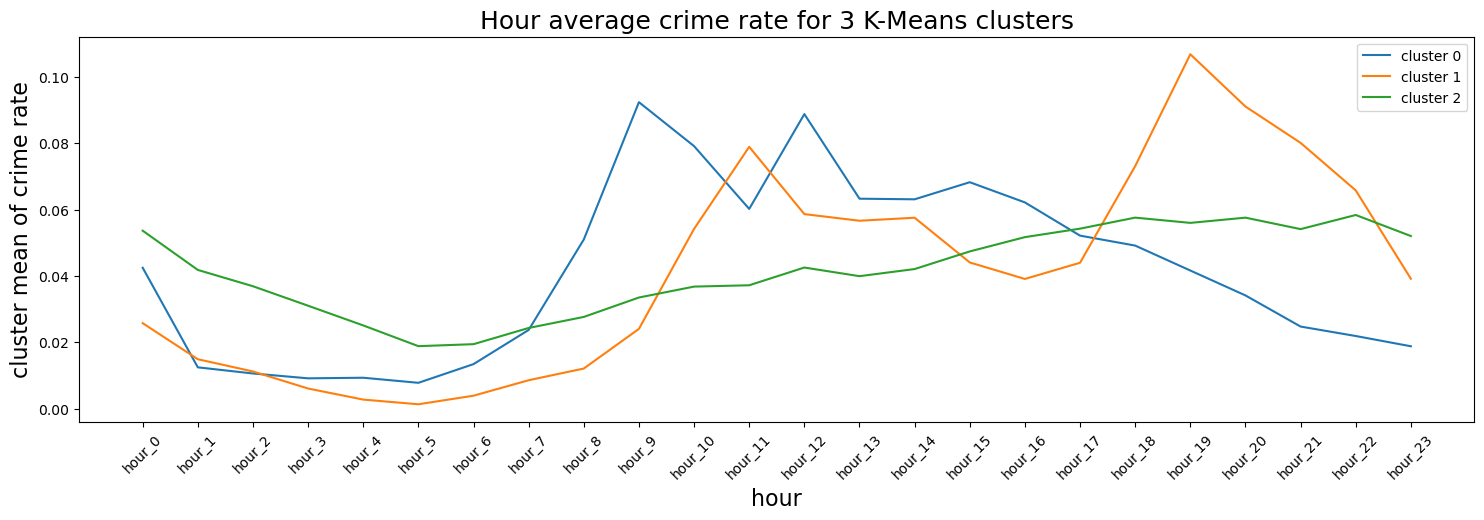

In [10]:
cluster_hour_mean = hour_data.groupby(['kmeans_lable']).mean()

ax = plt.figure(figsize = (18,5))
plt.plot(cluster_hour_mean.loc[0], label = 'cluster 0')
plt.plot(cluster_hour_mean.loc[1], label = 'cluster 1')
plt.plot(cluster_hour_mean.loc[2], label = 'cluster 2')
plt.legend(loc = 'upper right')
plt.title('Hour average crime rate for 3 K-Means clusters', fontsize=18)
plt.xlabel('hour',fontsize=16)
plt.ylabel('cluster mean of crime rate', fontsize=16)
plt.xticks(rotation=45)
plt.show()

#### b) Describe the three different hour-of-day trends represented by these three clusters (5%).

1. Cluster 0 (Blue Line): This cluster generally shows a decreasing trend in crime rate from midnight to the early morning hours.

2. Cluster 1 (Orange Line): This cluster starts with a higher crime rate at midnight, which sharply decreases and hits the lowest point around hour 5.

3. Cluster 2 (Green Line): The trend for this cluster is relatively stable in the early hours.

#### c) Do you notice any consistent trends about which crime types are assigned to which cluster?  Note that by a "crime type", we are referring to specific crimes such as "narcotics" or "assault", not the FBI categories. (5%)  

In [11]:
data3.groupby(['kmeans_lable','crime_type'])['Category'].count()

kmeans_lable  crime_type                                            
0             ASSAULT: PRO EMP HANDS NO/MIN INJURY                      1
              BATTERY: PRO EMP HANDS NO/MIN INJURY                      1
              BURGLARY: UNLAWFUL ENTRY                                  1
              DECEPTIVE PRACTICE: ATTEMPT - FINANCIAL IDENTITY THEFT    1
              DECEPTIVE PRACTICE: BOGUS CHECK                           1
                                                                       ..
2             THEFT: POCKET-PICKING                                     1
              THEFT: PURSE-SNATCHING                                    1
              WEAPONS VIOLATION: RECKLESS FIREARM DISCHARGE             1
              WEAPONS VIOLATION: UNLAWFUL USE HANDGUN                   1
              WEAPONS VIOLATION: UNLAWFUL USE OTHER DANG WEAPON         1
Name: Category, Length: 119, dtype: int64

- Cluster 0 : assault, deceptive practice, and other
- Cluster 1 : narcotics and other offense (gun related, license, and sex offender)
- Cluster 2 : theft and weapon violations 

#### d) Do the three clusters have different day-of-week trends? Again, visualize the trends for each cluster by creating a line graph and discuss any notable differences. (5%)

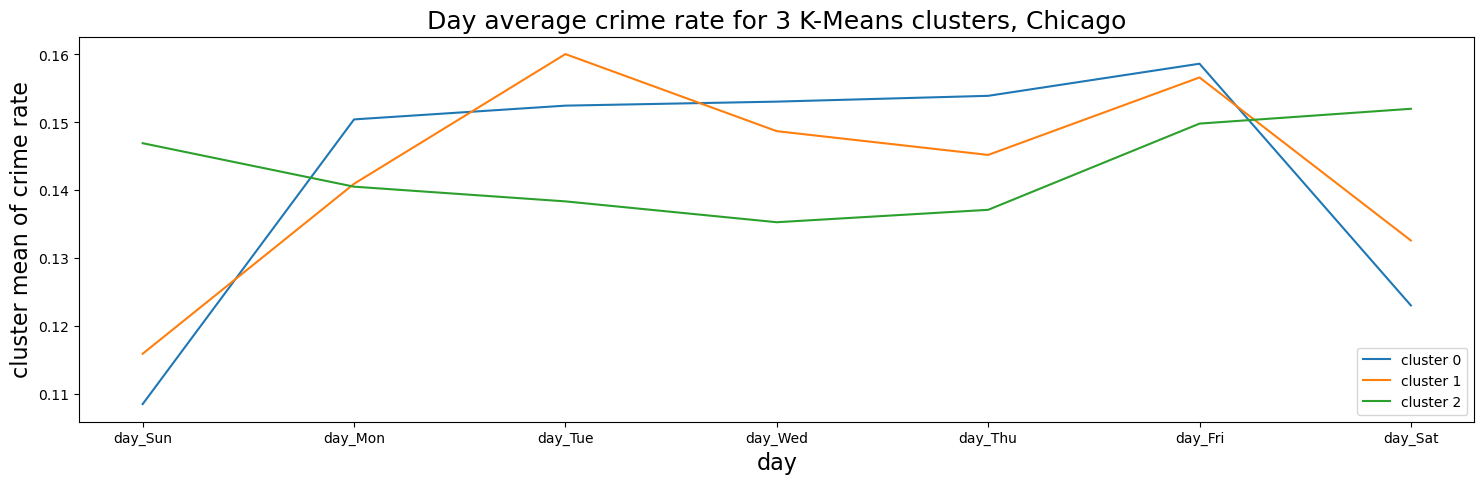

In [12]:
day_data = data3.iloc[:,[2,3,4,5,6,7,8,110]]
cluster_day_mean = day_data.groupby(['kmeans_lable']).mean()

#draw the plot
ax = plt.figure(figsize = (18,5))
plt.plot(cluster_day_mean.loc[0], label = 'cluster 0')
plt.plot(cluster_day_mean.loc[1], label = 'cluster 1')
plt.plot(cluster_day_mean.loc[2], label = 'cluster 2')
plt.legend(loc = 'lower right')
plt.title('Day average crime rate for 3 K-Means clusters, Chicago', fontsize=18)
plt.xlabel('day',fontsize=16)
plt.ylabel('cluster mean of crime rate', fontsize=16)
plt.show()

In [21]:
data3

,crime_type,Category,day_Sun,day_Mon,day_Tue,day_Wed,day_Thu,day_Fri,day_Sat,hour_0,...,community_area_69,community_area_70,community_area_71,community_area_72,community_area_73,community_area_74,community_area_75,community_area_76,community_area_77,kmeans_lable
0,ARSON: BY FIRE,P1P,0.138810,0.135977,0.155807,0.121813,0.130312,0.147309,0.169972,0.073654,...,0.016997,0.019830,0.022663,0.005666,0.000000,0.002833,0.005666,0.000000,0.002833,2
1,ASSAULT: AGG PO HANDS NO/MIN INJURY,P2,0.151852,0.118519,0.162963,0.122222,0.129630,0.129630,0.185185,0.055556,...,0.048148,0.018519,0.025926,0.003704,0.003704,0.003704,0.011111,0.011111,0.007407,2
2,ASSAULT: AGGRAVATED: HANDGUN,P1V,0.149912,0.139405,0.141506,0.131349,0.136953,0.133100,0.167776,0.040630,...,0.031524,0.013310,0.042732,0.002102,0.017863,0.000000,0.012259,0.002102,0.003152,2
3,ASSAULT: AGGRAVATED: OTHER DANG WEAPON,P1V,0.125000,0.139000,0.148000,0.153000,0.133000,0.142000,0.160000,0.034000,...,0.030000,0.014000,0.037000,0.003000,0.010000,0.002000,0.002000,0.003000,0.006000,2
4,ASSAULT: AGGRAVATED: OTHER FIREARM,P1V,0.156863,0.107843,0.166667,0.117647,0.147059,0.117647,0.186275,0.009804,...,0.019608,0.009804,0.019608,0.000000,0.000000,0.000000,0.009804,0.000000,0.000000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,THEFT: RETAIL THEFT,P1P,0.119700,0.143231,0.140389,0.144367,0.147209,0.153007,0.152097,0.008185,...,0.016824,0.008185,0.018415,0.001591,0.007389,0.002160,0.008980,0.003069,0.020462,0
115,WEAPONS VIOLATION: RECKLESS FIREARM DISCHARGE,P2,0.180672,0.096639,0.147059,0.092437,0.138655,0.142857,0.201681,0.054622,...,0.016807,0.004202,0.012605,0.004202,0.000000,0.000000,0.004202,0.000000,0.004202,2
116,WEAPONS VIOLATION: UNLAWFUL POSS OF HANDGUN,P2,0.142334,0.133388,0.150468,0.145181,0.125661,0.149654,0.153314,0.050834,...,0.034160,0.004067,0.044734,0.002033,0.016267,0.000000,0.005693,0.000813,0.002033,1
117,WEAPONS VIOLATION: UNLAWFUL USE HANDGUN,P2,0.177122,0.114391,0.132841,0.143911,0.140221,0.121771,0.169742,0.073801,...,0.025830,0.000000,0.033210,0.003690,0.007380,0.000000,0.014760,0.000000,0.033210,2


There are2 types of different patterns. We could see that on Mon-Thu cluster 2 has a lower mean crime rate while cluster 0 and 1 have higher ones. For Fri - Sun, cluster 2 has higher mean rate while cluster 0 and 1 has higher ones

#### e) Do the three clusters affect different types of communities/neighborhoods?  To answer this question, you could first compute the proportions of "cluster 1", "cluster 2", and "cluster 3" crimes for each community area, and identify particular community areas with disproportionate amounts of a given cluster.  You can then use the provided file (HW3Q3_2.csv), to determine whether these community areas have any notable common characteristics (poverty, overcrowding, etc.).  You may also wish to consult the Chicago Community Areas map at https://en.wikipedia.org/wiki/Community_areas_in_Chicago. (5%)

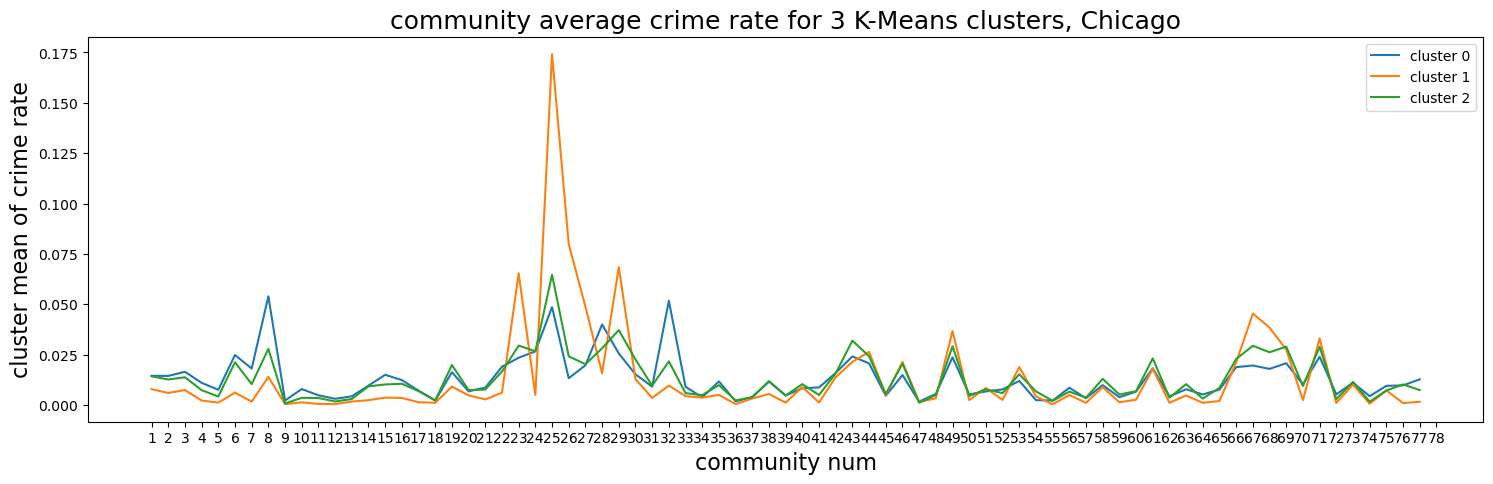

In [13]:
community_data = data3.loc[:,'community_area_1':'kmeans_lable']
cluster_com_mean = community_data.groupby(['kmeans_lable']).mean()

ax = plt.figure(figsize = (18,5))
plt.plot(cluster_com_mean.loc[0], label = 'cluster 0')
plt.plot(cluster_com_mean.loc[1], label = 'cluster 1')
plt.plot(cluster_com_mean.loc[2], label = 'cluster 2')

plt.legend(loc = 'upper right')
plt.title('community average crime rate for 3 K-Means clusters, Chicago', fontsize=18)
plt.ylabel('cluster mean of crime rate', fontsize=16)
plt.xlabel('community num',fontsize=16)
plt.xticks(range(0,78),range(1,79))
plt.show()

For each cluster choose 5 location that has highest propotion to see their characteristic.

In [14]:
cluster_0_demo = data4.loc[data4['Community Area Number'].isin([8,32,35,15,77])]
cluster_1_demo = data4.loc[data4['Community Area Number'].isin([23,25,29,49,67])]
cluster_2_demo = data4.loc[data4['Community Area Number'].isin([19,43,58,61,63])]

summary = pd.DataFrame()
summary.loc['mean0', data4.columns[4:11]] = cluster_0_demo.iloc[:, 4:11].mean()
summary.loc['mean1', data4.columns[4:11]] = cluster_1_demo.iloc[:, 4:11].mean()
summary.loc['mean2', data4.columns[4:11]] = cluster_2_demo.iloc[:, 4:11].mean()
summary.loc['totalmean', data4.columns[4:11]] = data4.iloc[:, 4:11].mean()
summary

,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,PERCENT OF HOUSING UNITS VACANT
mean0,2.680000,17.400000,10.540000,9.780000,24.920000,47141.400000,15.219242
mean1,7.160000,31.960000,23.460000,26.120000,40.100000,14207.600000,17.527254
mean2,11.140000,25.160000,17.940000,37.880000,38.000000,14576.800000,14.015106
totalmean,4.923377,21.766234,15.372727,20.341558,35.746753,25563.168831,12.442935


- cluster 0 has lower percent of housing crowded, and high income. When refering Chicago community map, we could see that all those communities are located near loop area. High population mobility could be a reason for higher assault and a various range of other crime.
- cluster 1 has high percent of household below poverty and high percent aged 16+ unemployed.
- cluster 2 has high percent of aged 25+ without high school diploma and high percent aged under 18 or over 64.




#### f) How well do the three groups formed by clustering hour-of-day trends correspond to the FBI’s division between P1V, P1P, and P2 crimes? (5%)


In [15]:
fbi_data = data3[['Category','kmeans_lable']]
for i in range(0,3):
    print('for cluster %d' %i)
    print(fbi_data[fbi_data['kmeans_lable']==i].Category.value_counts())
    print(fbi_data[fbi_data['kmeans_lable']==i].Category.value_counts(normalize=True))
    print('\n')

for cluster 0
P2     23
P1P     4
Name: Category, dtype: int64
P2     0.851852
P1P    0.148148
Name: Category, dtype: float64


for cluster 1
P2    23
Name: Category, dtype: int64
P2    1.0
Name: Category, dtype: float64


for cluster 2
P2     34
P1V    24
P1P    11
Name: Category, dtype: int64
P2     0.492754
P1V    0.347826
P1P    0.159420
Name: Category, dtype: float64





#### g) For part g, you will use the same dataset to compare the clusters produced by several different methods.  But this time you should cluster using only the _day-of-week_ (not hour-of-day) attributes (day_Sun..day_Sat).  Please perform four different clusterings using (i) k-means, (ii) Gaussian mixture models, (iii) Bottom-up hierarchical clustering with "single link" distance metric, and (iv) Bottom-up hierarchical clustering with "complete link" distance metric.  In each case, you should choose the number of clusters using the silhouette method (or another established method of your choice- please specify).  For each clustering, report the number of clusters formed and the number of elements in each cluster. You should also identify any notable similarities or differences between the clusterings. (20%)

In [16]:
cluster_data = data3.loc[:,"day_Sun":"day_Sat"]

(i) k-means

In [17]:
cluster_num = {}
for n_clusters in range(2,10):
    clusterer = KMeans(random_state=2019, n_clusters=n_clusters)
    preds = clusterer.fit_predict(cluster_data)
    #centers = clusterer.cluster_centers_

    score = silhouette_score (cluster_data, preds)
    cluster_num[n_clusters] = score

best_cluster = max(cluster_num, key=cluster_num.get)

kmeans_cl = KMeans(n_clusters = best_cluster, random_state= 2019)
fit_kmeans = kmeans_cl.fit(cluster_data)
kmeans_data = cluster_data.copy()
kmeans_data['kmeans_lable'] = fit_kmeans.labels_

print ("\n The cluster number for Single link is:",best_cluster, "distribution of each category is: ")
print (kmeans_data['kmeans_lable'].value_counts())


 The cluster number for Single link is: 2 distribution of each category is: 
1    63
0    56
Name: kmeans_lable, dtype: int64


(ii) Gaussian mixture models

In [18]:
cluster_num = {}
for n_clusters in range(2,10):
    clusterer = GaussianMixture(random_state=2019, n_components=n_clusters)
    preds = clusterer.fit_predict(cluster_data)
    #centers = clusterer.cluster_centers_

    score = silhouette_score (cluster_data, preds)
    cluster_num[n_clusters] = score

best_cluster = max(cluster_num, key=cluster_num.get)

gmm = GaussianMixture(random_state=2019, n_components=best_cluster)
fit_gmm = gmm.fit_predict(cluster_data)


gmm_data = cluster_data.copy()
gmm_data['gmm_lable'] = fit_gmm

print ("\n The cluster number for Single link is:",best_cluster, "distribution of each category is: ")
print (gmm_data['gmm_lable'].value_counts())


 The cluster number for Single link is: 2 distribution of each category is: 
1    93
0    26
Name: gmm_lable, dtype: int64


(iii) Bottom-up hierarchical clustering with "single link" distance metric

In [19]:
Z_single = linkage(cluster_data, 'single')
cluster_num = {}
for n_clusters in range(2,10):
    preds = fcluster(Z_single, n_clusters, criterion='maxclust')

    score = silhouette_score (cluster_data, preds)
    cluster_num[n_clusters] = score

best_cluster = max(cluster_num, key=cluster_num.get)

sl_label=fcluster(Z_single, best_cluster, criterion='maxclust') 
sl_data=cluster_data.copy()
sl_data['sl_label'] = sl_label

print ("\n The cluster number for Single link is:",best_cluster, "distribution of each category is: ")
print (sl_data['sl_label'].value_counts())


 The cluster number for Single link is: 2 distribution of each category is: 
1    118
2      1
Name: sl_label, dtype: int64


(iv) Bottom-up hierarchical clustering with "complete link" distance metric

In [20]:
Z_complete = linkage(cluster_data, 'complete')
cluster_num = {}
for n_clusters in range(2,10):
    preds = fcluster(Z_complete, n_clusters, criterion='maxclust')

    score = silhouette_score (cluster_data, preds)
    cluster_num[n_clusters] = score

best_cluster = max(cluster_num, key=cluster_num.get)

cl_label=fcluster(Z_complete, best_cluster, criterion='maxclust') 
cl_data=cluster_data.copy()
cl_data['cl_label'] = cl_label

print ("\n The cluster number for Single link is:",best_cluster, "distribution of each category is: ")
print (cl_data['cl_label'].value_counts())


 The cluster number for Single link is: 2 distribution of each category is: 
2    117
1      2
Name: cl_label, dtype: int64


Complete link and single link clusters has similar cluster output. They both have two categories (one of them has almost all elements in the datasets). In this case, since we did not prune out link, at the final stage, the bottom up hierarchical clustering (both types) will have similar output.